In [259]:
!java -version


!pip install pyspark --quiet

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("ColabPySpark") \
    .getOrCreate()

spark

openjdk version "17.0.16" 2025-07-15
OpenJDK Runtime Environment (build 17.0.16+8-Ubuntu-0ubuntu122.04.1)
OpenJDK 64-Bit Server VM (build 17.0.16+8-Ubuntu-0ubuntu122.04.1, mixed mode, sharing)


Reading in dataset that was produced from data cleaning.  

In [260]:
df = spark.read.csv("/content/final_df.csv", header=True,inferSchema=True)


In [261]:
import os
os.environ["PYSPARK_SUBMIT_ARGS"] = \
    "--packages org.apache.spark:spark-sql_2.12:3.5.0,ml.dmlc:xgboost4j-spark_2.12:1.7.6 pyspark-shell"


Downloading libraries

In [262]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import log, exp, col
from pyspark.ml.regression import LinearRegression
from xgboost.spark import SparkXGBRegressor


import os
os.environ["PYSPARK_SUBMIT_ARGS"] = \
    "--packages org.apache.spark:spark-sql_2.12:3.5.0,ml.dmlc:xgboost4j-spark_2.12:1.7.6 pyspark-shell"

In [263]:
from pyspark.ml.feature import StringIndexer

town_indexer = StringIndexer(inputCol="town", outputCol="town_index")
df = town_indexer.fit(df).transform(df)

county_indexer = StringIndexer(inputCol="County", outputCol="county_index")
df = county_indexer.fit(df).transform(df)

# df = df.withColumn("Price_2", log(col("Price_2")))



One hot encoding town and county columns

In [264]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(
    inputCols=["town_index", "county_index"],
    outputCols=["town_vec", "county_vec"],
    dropLast=True
)

df = encoder.fit(df).transform(df)


Removing outliers using Inter Quantile range

In [265]:
from pyspark.sql import functions as F


quantiles = df.approxQuantile("Price_2", [0.25, 0.75], 0.05)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df.filter((F.col("Price_2") >= lower_bound) & (F.col("Price_2") <= upper_bound))


Processing date and urban_rural column

In [266]:

from pyspark.ml.feature import OneHotEncoder

from pyspark.ml.feature import StringIndexer


from pyspark.sql.functions import to_date, col

df = df.withColumn(
    "Date of Sale (dd/mm/yyyy)",
    to_date(col("Date of Sale (dd/mm/yyyy)"), "dd/MM/yyyy")
)
from pyspark.sql.functions import year, month, dayofmonth, dayofweek

df = df.withColumn("year", year(col("Date of Sale (dd/mm/yyyy)"))) \
       .withColumn("month", month(col("Date of Sale (dd/mm/yyyy)"))) \
       .withColumn("day", dayofmonth(col("Date of Sale (dd/mm/yyyy)")))



from pyspark.sql.functions import when, col

df = df.withColumn(
    "urban_dummy",
    when(col("urban_rural") == "urban", 1).otherwise(0)
)

urban_df = df.filter(col("urban_dummy") == 1)


Using VectorAssembler to turn the features into one vector

In [267]:
from pyspark.ml.feature import VectorAssembler

feature_cols = ["year", "urban_dummy", "town_vec", "county_vec"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)


In [268]:
df.show()

+-------------------------+--------------------+---------+---------+------+-----------+-----------------------+----------+------------+------------------+---------------+----+-----+---+-----------+--------------------+
|Date of Sale (dd/mm/yyyy)|             Address|  Price_2|     town|County|urban_rural|Description of Property|town_index|county_index|          town_vec|     county_vec|year|month|day|urban_dummy|            features|
+-------------------------+--------------------+---------+---------+------+-----------+-----------------------+----------+------------+------------------+---------------+----+-----+---+-----------+--------------------+
|               2015-12-07|20 College Woods,...|  69500.0|    balla|  mayo|      urban|   New Dwelling hous...|     439.0|        13.0|(1780,[439],[1.0])|(25,[13],[1.0])|2015|   12|  7|          1|(1807,[0,1,441,17...|
|               2015-01-30|       Prizon, Balla| 115000.0|    balla|  mayo|      urban|   New Dwelling hous...|     439.0|  

Setting price as target and splitting columns

In [269]:
TARGET = "Price_2"
non_features = ['Address']

df = df.filter(col(TARGET).isNotNull())

train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)


RandomForestRegressor model

In [270]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="Price_2",
    numTrees=50,
    maxDepth=4
)
lr = LinearRegression(featuresCol="features", labelCol="Price_2")
model = lr.fit(df)

model = lr.fit(train_df)

Evaluating model

In [271]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = model.transform(test_df)

evaluator_rmse = RegressionEvaluator(labelCol="Price_2", predictionCol="prediction", metricName="rmse")
evaluator_mae  = RegressionEvaluator(labelCol="Price_2", predictionCol="prediction", metricName="mae")
evaluator_r2   = RegressionEvaluator(labelCol="Price_2", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae  = evaluator_mae.evaluate(predictions)
r2   = evaluator_r2.evaluate(predictions)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

MAE: 76636.29432267522
RMSE: 100812.38624801296
R²: 0.4588834583635123


Training XGBoost model

In [272]:


xgb = SparkXGBRegressor(
    features_col="features",
    label_col="Price_2",
    num_workers=spark.sparkContext.defaultParallelism,
    max_depth=8,
    eta=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    n_estimators=250,
    tree_method='hist',
)


model = xgb.fit(train_df)




Evaluating model

In [273]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = model.transform(test_df)
evaluator_rmse = RegressionEvaluator(labelCol="Price_2", predictionCol="prediction", metricName="rmse")
evaluator_mae  = RegressionEvaluator(labelCol="Price_2", predictionCol="prediction", metricName="mae")
evaluator_r2   = RegressionEvaluator(labelCol="Price_2", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae  = evaluator_mae.evaluate(predictions)
r2   = evaluator_r2.evaluate(predictions)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)


MAE: 76383.1014064869
RMSE: 100459.45408503852
R²: 0.46266559553792164


Analysing which perfomred better urban or rural for xgboost

In [274]:
from pyspark.sql.functions import col, pow, mean, sqrt

predictions = predictions.withColumn("residual_sq", pow(col("Price_2") - col("prediction"), 2))

rmse_by_group = predictions.groupBy("urban_rural").agg(
    sqrt(mean(col("residual_sq"))).alias("rmse")
)

rmse_by_group.show()


+-----------+------------------+
|urban_rural|              rmse|
+-----------+------------------+
|      rural|106034.90254401503|
|      urban| 98954.23032246139|
+-----------+------------------+



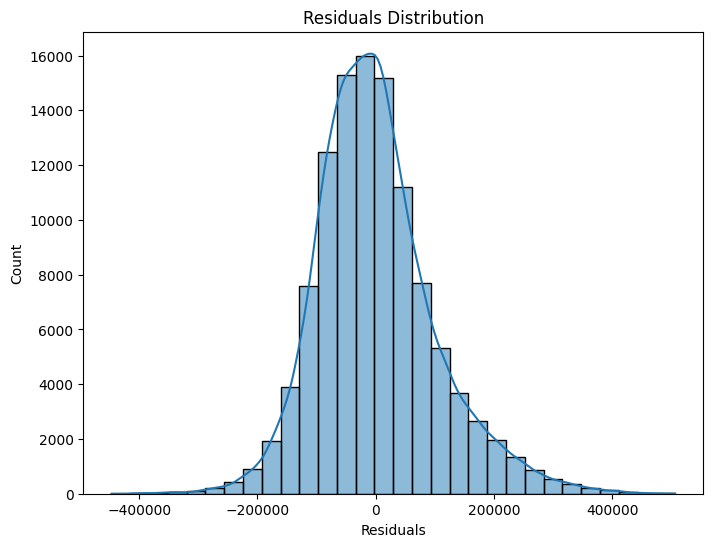

In [275]:
import matplotlib.pyplot as plt
import seaborn as sns


predictions = predictions.withColumn("residual", predictions["Price_2"] - predictions["prediction"])

pred_pd = predictions.select("Price_2", "prediction", "residual").toPandas()


plt.figure(figsize=(8,6))
sns.histplot(pred_pd["residual"], kde=True, bins=30)
plt.xlabel("Residuals")
plt.title("Residuals Distribution")
plt.show()


In [276]:
from pyspark.sql.functions import col, pow, sqrt, expr

predictions = predictions.withColumn("residual_sq", pow(col("Price_2") - col("prediction"), 2))

rmse_median_df = predictions.groupBy("county").agg(
    sqrt(expr("mean(residual_sq)")).alias("rmse"),
    expr("percentile_approx(Price_2, 0.5)").alias("median_price")  # median
)

rmse_median_df = rmse_median_df.withColumn("rmse_pct", col("rmse") / col("median_price") * 100)

rmse_median_df.orderBy(col("rmse_pct").desc()).show(26, truncate=False)


+---------+------------------+------------+------------------+
|county   |rmse              |median_price|rmse_pct          |
+---------+------------------+------------+------------------+
|leitrim  |84013.71773854838 |115000.0    |73.0554067291725  |
|sligo    |101078.84428628537|140000.0    |72.19917449020383 |
|longford |73016.02204337594 |102000.0    |71.58433533664308 |
|donegal  |83980.27661128232 |118000.0    |71.16972594176467 |
|roscommon|77498.48348410688 |110000.0    |70.45316680373352 |
|mayo     |89940.66697161361 |135000.0    |66.62271627526934 |
|tipperary|92203.3566300268  |148000.0    |62.29956529055865 |
|waterford|103245.14473251575|167400.88   |61.67538947974213 |
|kerry    |98584.31930738584 |160000.0    |61.61519956711615 |
|monaghan |87716.85450399837 |143000.0    |61.34045769510376 |
|clare    |94927.89657964135 |160000.0    |59.32993536227584 |
|cavan    |79508.58990111414 |139215.0    |57.11208555192626 |
|limerick |101611.38200776622|180000.0    |56.450767782

In [277]:
from pyspark.sql.functions import col, pow, sqrt, expr

predictions = predictions.withColumn("residual_sq", pow(col("Price_2") - col("prediction"), 2))

rmse_median_df = predictions.groupBy("town").agg(
    sqrt(expr("mean(residual_sq)")).alias("rmse"),
    expr("percentile_approx(Price_2, 0.5)").alias("median_price")  # median
)

rmse_median_df = rmse_median_df.withColumn("rmse_pct", col("rmse") / col("median_price") * 100)

rmse_median_df.orderBy(col("rmse_pct").desc()).show(20, truncate=False)

+------------+------------------+------------+------------------+
|town        |rmse              |median_price|rmse_pct          |
+------------+------------------+------------+------------------+
|carrigkerry |130187.34375      |7500.0      |1735.83125        |
|coolboy     |271531.70145057136|18750.0     |1448.1690744030473|
|clondulane  |203754.8125       |15000.0     |1358.3654166666668|
|rear cross  |236057.75         |21250.0     |1110.86           |
|ahascragh   |106605.65597082191|10000.0     |1066.056559708219 |
|dooagh      |107410.08911505138|11180.0     |960.7342496874006 |
|scartaglin  |113336.05217426516|13000.0     |871.815785955886  |
|ballynacally|136305.73415970764|20000.0     |681.5286707985382 |
|rostellan   |262102.40625      |40005.0     |655.1741188601425 |
|knockaderry |130422.84375      |20000.0     |652.11421875      |
|rockchapel  |161480.5345914917 |30000.0     |538.2684486383057 |
|rathdangan  |234168.01659235032|45000.0     |520.373370205223  |
|meelin   

In [278]:
from pyspark.sql.functions import col, pow, sqrt, expr

predictions = predictions.withColumn("residual_sq", pow(col("Price_2") - col("prediction"), 2))

rmse_median_df = predictions.groupBy("town").agg(
    sqrt(expr("mean(residual_sq)")).alias("rmse"),
    expr("percentile_approx(Price_2, 0.5)").alias("median_price")  # median
)

rmse_median_df = rmse_median_df.withColumn("rmse_pct", col("rmse") / col("median_price") * 100)

rmse_median_df.orderBy(col("rmse_pct").asc()).show(20, truncate=False)

+-----------+------------------+------------+------------------+
|town       |rmse              |median_price|rmse_pct          |
+-----------+------------------+------------+------------------+
|rathcool   |3293.53125        |225000.0    |1.4637916666666668|
|kilfinnane |2312.65625        |140000.0    |1.6518973214285713|
|bealadangan|3479.0625         |195000.0    |1.7841346153846156|
|partry     |3765.6850855229623|157500.0    |2.3909111654114046|
|dromcondra |8810.09375        |330000.0    |2.6697253787878785|
|maum       |5106.21875        |165000.0    |3.0946780303030303|
|northlands |20617.875         |401000.0    |5.141614713216958 |
|kilskeer   |11392.140625      |200000.0    |5.6960703125      |
|tynagh     |8939.9375         |140000.0    |6.385669642857144 |
|gusserane  |13210.09375       |205000.0    |6.443948170731708 |
|clonbern   |25871.75          |370000.0    |6.992364864864865 |
|newcestown |16158.515625      |220000.0    |7.3447798295454545|
|ballycroy  |15134.078125

In [279]:
from pyspark.sql.functions import col, pow, sqrt, expr

predictions = predictions.withColumn("residual_sq", pow(col("Price_2") - col("prediction"), 2))

rmse_median_df = predictions.groupBy("town").agg(
    sqrt(expr("mean(residual_sq)")).alias("rmse"),
    expr("percentile_approx(Price_2, 0.5)").alias("median_price")  # median
)

rmse_median_df = rmse_median_df.withColumn("rmse_pct", col("rmse") / col("median_price") * 100)

rmse_median_df.orderBy(col("median_price").desc()).show(20, truncate=False)


+--------------+------------------+------------+------------------+
|town          |rmse              |median_price|rmse_pct          |
+--------------+------------------+------------+------------------+
|kilcorney     |365391.4375       |640000.0    |57.092412109375005|
|two mile house|411751.890625     |625000.0    |65.8803025        |
|aghaboe       |345094.0          |590000.0    |58.490508474576274|
|ahakista      |274966.34375      |550000.0    |49.99388068181818 |
|kilmacud      |152017.40597732685|525000.0    |28.95569637663369 |
|brannockstown |236032.43158077853|511013.21   |46.18910567513089 |
|foxrock       |128991.63387950891|499400.0    |25.82932196225649 |
|portmarnock   |126688.31544767512|480177.0    |26.38367007325947 |
|carrickmines  |135074.9002476991 |480000.0    |28.140604218270642|
|enniskerry    |150948.33826713182|480000.0    |31.447570472319132|
|templeogue    |112048.82480414517|477500.0    |23.465722472072287|
|rathfeigh     |245766.046875     |475000.0    |

In [280]:
from pyspark.ml.feature import VectorAssembler

feature_cols = ["year", "urban_dummy", "town_vec", "county_vec"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(urban_df)

In [281]:
TARGET = "Price_2"
non_features = ['Address']

df = df.filter(col(TARGET).isNotNull())

train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

In [282]:

xgb = SparkXGBRegressor(
    features_col="features",
    label_col="Price_2",
    num_workers=spark.sparkContext.defaultParallelism,
    max_depth=8,
    eta=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    n_estimators=250,
    tree_method='hist',
)


model = xgb.fit(train_df)

/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


In [283]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = model.transform(test_df)
evaluator_rmse = RegressionEvaluator(labelCol="Price_2", predictionCol="prediction", metricName="rmse")
evaluator_mae  = RegressionEvaluator(labelCol="Price_2", predictionCol="prediction", metricName="mae")
evaluator_r2   = RegressionEvaluator(labelCol="Price_2", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae  = evaluator_mae.evaluate(predictions)
r2   = evaluator_r2.evaluate(predictions)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

MAE: 75104.91667166367
RMSE: 99019.86915820633
R²: 0.4973861091464481
